In [24]:

# Default locations if parameter not passed
benchmark_data_path = "big_matrix.pkl"


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])


rprint(df.columns)
rprint(df.head())
rprint(df.tail())

Index(['name', 'simu_rr', 'biggest_matrix', 'full_output', 'node_count',
       'hosts', 'time'],
      dtype='object')

name  simu_rr  biggest_matrix full_output  node_count  \
0  big-matrix      NaN             NaN         NaN         4.0   
1  big-matrix      NaN             NaN         NaN         4.0   
2  big-matrix      NaN             NaN         NaN         4.0   
3  big-matrix      NaN             NaN         NaN         4.0   
4  big-matrix      NaN             NaN         NaN         4.0   

                                             hosts       time  
0  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  55.652090  
1  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  55.535929  
2  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  51.116344  
3  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  49.957348  
4  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  57.171717

name  simu_rr  biggest_matrix  \
15  simulator-matrix-feed      4.0             4.0   
16  simulator-matrix-feed      4.0             4.0   
17  simulator-matrix-feed      4.0             4.0   
18  simulator-matrix-feed      4.0             4.0   
19  simulator-matrix-feed      4.0             4.0   

                                          full_output  node_count  \
15  Time Simulation (microseconds) : 7701 \nDistan...         NaN   
16  Time Simulation (microseconds) : 7644 \nDistan...         NaN   
17  Time Simulation (microseconds) : 7737 \nDistan...         NaN   
18  Time Simulation (microseconds) : 7711 \nDistan...         NaN   
19  Time Simulation (microseconds) : 7655 \nDistan...         NaN   

                                              hosts      time  
15  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  0.540424  
16  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  0.538804  
17  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  0.542967  
18  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  0.542302  
19  sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4  0.537096

In [26]:
sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

In [27]:
def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [28]:
bench_names = df["name"].unique()
run_metadata = benchmark_data["config"].applications

max_node_count = 0

for bench in bench_names:
    bench_metadata = run_metadata[bench]
    n_runs = benchmark_data["config"].metadata.runs
    print(f"Benchmark: {bench} - Runs: {n_runs}")
    # print(bench_metadata)
    df_bench = df[df["name"] == bench]
    for idx, row in df_bench.iterrows():
        print(f"--- Row {idx} ---")
        if "node_count" in row:
            node_count = row["node_count"]
            if node_count > max_node_count:
                max_node_count = node_count
        for col, val in row.items():
            print(f"{col}: {val}")   # printing val directly never truncates
        print()

max_node_count = int(max_node_count)
print(f"Max node count: {max_node_count}")

Benchmark: big-matrix - Runs: 5
--- Row 0 ---
name: big-matrix
simu_rr: nan
biggest_matrix: nan
full_output: nan
node_count: 4.0
hosts: sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4
time: 55.65209010010585

--- Row 1 ---
name: big-matrix
simu_rr: nan
biggest_matrix: nan
full_output: nan
node_count: 4.0
hosts: sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4
time: 55.53592872316949

--- Row 2 ---
name: big-matrix
simu_rr: nan
biggest_matrix: nan
full_output: nan
node_count: 4.0
hosts: sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4
time: 51.11634427309036

--- Row 3 ---
name: big-matrix
simu_rr: nan
biggest_matrix: nan
full_output: nan
node_count: 4.0
hosts: sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4
time: 49.95734805311076

--- Row 4 ---
name: big-matrix
simu_rr: nan
biggest_matrix: nan
full_output: nan
node_count: 4.0
hosts: sorgan-cpu1,sorgan-cpu2,sorgan-cpu3,sorgan-cpu4
time: 57.171717097982764

Benchmark: simulator-matrix-feed - Runs: 5
--- Row 5 ---
name: simulator-matrix-fe

# Experiment 1
x-axis: SIM_RR
y_axis: distance 

In [29]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def extract_distance(text):
    matches = re.findall(
        r"Distance\s*:\s*([-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?)",
        str(text)
    )
    return float(matches[-1]) if matches else np.nan

In [30]:
df_dist = df[df["name"] == "simulator-matrix-feed"].copy()
df_dist["distance"] = df_dist["full_output"].apply(extract_distance)
df_dist = df_dist[["simu_rr", "distance"]]

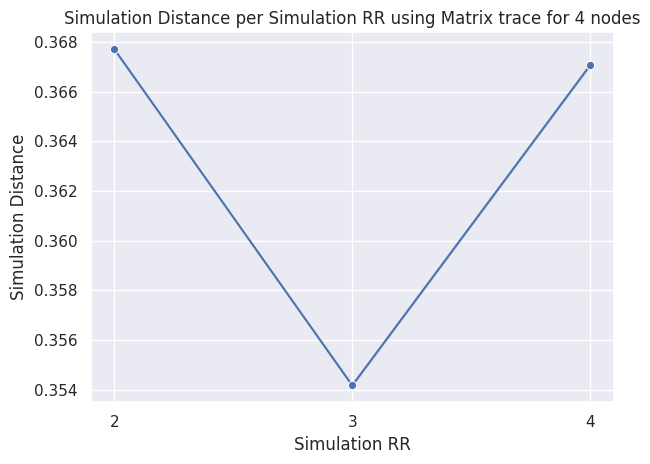

In [31]:
plt.figure()
sns.lineplot(
  data=df_dist,
  x="simu_rr",
  y="distance",
  marker="o",
  errorbar="ci",
)

plt.xlabel("Simulation RR")
plt.ylabel("Simulation Distance")
plt.title(f"Simulation Distance per Simulation RR using Matrix trace for {max_node_count} nodes")
plt.grid(True)
plt.xticks(sorted(df_dist["simu_rr"].unique()))
plt.tight_layout()
plt.show()